# Testing the Variable Projection method for Separable non-linear problems

@Author: Ettore Biondi - ettore88@stanford.edu

In this notebook we are going to test and explore the variable projection method (Golub and Pereyra, 1973) on a simple exponential fitting problem. This kind of inverse problem falls into the set of separable non-linear problems; therefore, the variable-projection method (VarPro) can and should be applied. The analytical/modeling equation is represented by the following:
\begin{align}
y_{i} = a \exp(-b t_{i}),
\end{align}
where $a$ and $b$ are the model parameters and $t_i$ indicates the $i-th$ time sample. We are going to minimize the simple $L_{2}$ difference between the model and the observed data. Hence, we can write the objective function as the following:
\begin{align}
\phi(a,b) = \frac{1}{2} \|\mathbf{y}(a,b) - \mathbf{y}_{obs} \|_2^2.
\end{align}
We notice that this objective function is quadratic with respect to parameter $a$ and non-linear with respect to the other.

### Importing necessary libraries

In [1]:
import time
import numpy as np
import occamypy
#Plotting library
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# %matplotlib inline
params = {
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex':True
}
matplotlib.rcParams.update(params)

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


### Defining non-linear modeling operator for symultaneous inversion
Here we define the model vector as $\mathbf{m}= [a,b]^{T}$

In [10]:
class exponential_nl_sym(occamypy.Operator):

    def __init__(self,model,t_vec):
        """y(a,b;t) = a * exp(-b*t) """
        self.setDomainRange(model,t_vec)
        self.t_samples = t_vec.getNdArray()
        return

    def forward(self,add,model,data):
        """Forward non-linear"""
        self.checkDomainRange(model,data)
        modelNd = model.getNdArray()
        dataNd = data.getNdArray()
        a = modelNd[0]
        b = modelNd[1]
        if not add: data.zero()
        dataNd += a * np.exp(-b*self.t_samples)
        return
    
class exponential_jac_sym(occamypy.Operator):

    def __init__(self, model, t_vec):
        """Jacobian matrix of the non-linear exponential for symultaneous inversion"""
        super(exponential_jac_sym, self).__init__(model, t_vec)
        self.m0 = model.clone()
        self.t_samples = t_vec.getNdArray()
        return

    def forward(self,add,model,data):
        """Forward jacobian"""
        self.checkDomainRange(model,data)
        modelNd = model.getNdArray()
        dataNd = data.getNdArray()
        da = modelNd[0]
        db = modelNd[1]
        a0 = self.m0.getNdArray()[0]
        b0 = self.m0.getNdArray()[1]
        if not add: data.zero()
        dataNd += da * np.exp(-b0*self.t_samples) - a0 * self.t_samples * db* np.exp(-b0*self.t_samples)
        return
    
    def adjoint(self,add,model,data):
        """Adjoint jacobian"""
        self.checkDomainRange(model,data)
        modelNd = model.getNdArray()
        dataNd = data.getNdArray()
        da = modelNd[0]
        db = modelNd[1]
        a0 = self.m0.getNdArray()[0]
        b0 = self.m0.getNdArray()[1]
        if not add: model.zero()
        modelNd[0] += np.sum(dataNd*np.exp(-b0*self.t_samples))
        modelNd[1] -= np.sum(dataNd*a0*self.t_samples*np.exp(-b0*self.t_samples))
        return
    
    def set_m0(self,m0):
        self.m0.copy(m0)
        return

In [14]:
#Generating observed data
time_vec = occamypy.VectorIC(np.linspace(0.,2.,200))
a_true = 10.0
b_true = 1.0
true_m = occamypy.VectorIC(np.array([a_true,b_true]))
modeling_op = exponential_nl_sym(true_m, time_vec)
data_true = time_vec.clone()
modeling_op.forward(False,true_m,data_true)

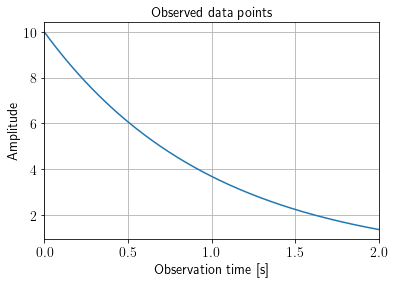

In [12]:
fig,ax=plt.subplots()
plt.plot(time_vec.getNdArray(),data_true.getNdArray())
plt.grid()
plt.title("Observed data points")
plt.xlabel("Observation time [s]")
plt.ylabel("Amplitude")
ax.autoscale(enable=True, axis='x', tight=True)

In [13]:
#Generating Jacobian of the non-linear operator
modeling_op_jac = exponential_jac_sym(true_m,time_vec)
non_lin_op = occamypy.NonlinearLeastSquares(modeling_op,modeling_op_jac,modeling_op_jac.set_m0)
#Instanciating non-linear problem
L2_sym = occamypy.NonlinearLeastSquares(true_m,data_true,non_lin_op)

AttributeError: 'exponential_nl_sym' object has no attribute 'clone'

In [6]:
#Computing the objective function for plotting
a_samples = np.linspace(0.0,30.0,500)
b_samples = np.linspace(-1.0,6.0,200)
obj_l2 = np.zeros((len(a_samples),len(b_samples)))
model_test = occamypy.VectorIC(np.array((0.0,0.0)))
model_test_np = model_test.getNdArray()
for ia,a_value in enumerate(a_samples):
        for ib,b_value in enumerate(b_samples):
                model_test_np[0] = a_value
                model_test_np[1] = b_value
                obj_l2[ia,ib]=L2_sym.get_obj(model_test)

NameError: name 'L2_sym' is not defined

/Users/francesco/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]


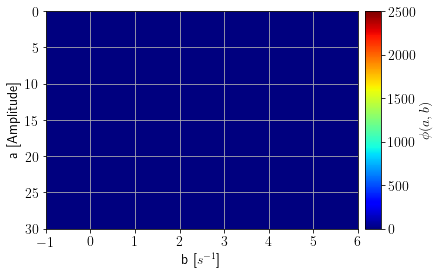

In [8]:
#Looking at the shape of the objective function
fig,ax=plt.subplots()
im=plt.imshow(obj_l2, vmin=0.0, vmax=2500, cmap='jet', extent=[-1.0,6.0,30.0,0.0])
plt.xlabel("b [$s^{-1}$]")
plt.ylabel("a [Amplitude]")
plt.grid()
cs = plt.contour(obj_l2,
                 levels=[1.0,10.0,100.0,500.0,1000.0,1500.0,2000.0,2500.0],
                 extent=[-1.0,6.0,0.0,30.0],
                 colors="black",
                 linewidths=(0.8,),
                 linestyles='--')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('$\phi(a,b)$')
ax.set_aspect('auto')

In [10]:
niter = 1000
Stop  = occamypy.BasicStopper(niter=niter, tolr=1e-32, tolg=1e-32)
NLCGsolver = occamypy.NLCG(Stop, beta_type="FR")
model_init = model_test
model_initNp = model_init.getNdArray()
a_initial = 2.0
b_initial = 0.0
model_initNp[0] = a_initial
model_initNp[1] = b_initial
#Setting initial model
_=L2_sym.get_obj(model_init)
L2_sym.setDefaults()
NLCGsolver.setDefaults(save_obj=True,save_model=True)
t0 = time.time()
NLCGsolver.run(L2_sym,verbose=True)
print("Computational time %s s"%(time.time()-t0))
objNLCG = np.copy(NLCGsolver.obj)
#Converting sampled points to arrays for plotting
a_smpld=[]
b_smpld=[]
for i in range(len(NLCGsolver.model)):
    a_smpld.append(NLCGsolver.model[i].getNdArray()[0])
    b_smpld.append(NLCGsolver.model[i].getNdArray()[1])

NameError: name 'L2_sym' is not defined

In [ ]:
#Looking at the optimization path
fig, ax = plt.subplots()
plt.scatter(b_smpld ,a_smpld, color='red' ,s=50, marker="+")
plt.plot(b_smpld, a_smpld, "--", color='red')
im=plt.imshow(obj_l2, vmin=0.0, vmax=2500, cmap='jet', extent=[-1.0,6.0,30.0,0.0])
plt.xlabel("b [$s^{-1}$]")
plt.ylabel("a [Amplitude]")
plt.grid()
cs = plt.contour(obj_l2,
                 levels=[1.0,10.0,100.0,500.0,1000.0,1500.0,2000.0,2500.0],
                 extent=[-1.0,6.0,0.0,30.0],
                 colors="black",
                 linewidths=(0.8,),
                 linestyles='--')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('$\phi(a,b)$')
ax.set_aspect('auto')

In [ ]:
BFGSsolver = occamypy.LBFGS(Stop)
#Setting initial model
_=L2_sym.get_obj(model_init)
L2_sym.setDefaults()
BFGSsolver.setDefaults(save_obj=True, save_model=True)
t0 = time.time()
BFGSsolver.run(L2_sym, verbose=True)
objBFGS = np.copy(BFGSsolver.obj)
print("Computational time %s s"%(time.time()-t0))
#Converting sampled points to arrays for plotting
a_smpld=[]
b_smpld=[]
for i in range(len(BFGSsolver.model)):
    a_smpld.append(BFGSsolver.model[i].getNdArray()[0])
    b_smpld.append(BFGSsolver.model[i].getNdArray()[1])

In [ ]:
#Looking at the optimization path
fig, ax = plt.subplots()
plt.scatter(b_smpld, a_smpld, color='red', s=50, marker="+")
plt.plot(b_smpld, a_smpld, "--", color='red')
im = plt.imshow(obj_l2, vmin=0.0, vmax=2500, cmap='jet', extent=[-1.0,6.0,30.0,0.0])
plt.xlabel("b [$s^{-1}$]")
plt.ylabel("a [Amplitude]")
plt.grid()
cs = plt.contour(obj_l2,
                 levels=[1.0,10.0,100.0,500.0,1000.0,1500.0,2000.0,2500.0],
                 extent=[-1.0,6.0,0.0,30.0],
                 colors="black",
                 linewidths=(0.8,),
                 linestyles='--')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('$\phi(a,b)$')
ax.set_aspect('auto')

Let's try to apply the VarPro method. Therefore, we reduce the number of model parameter to only $b$ because now $a$ is going to be function of $b$. In fact, we can write the new objective function as the following:
\begin{align}
\phi_{VarPro}(b) =  \frac{1}{2} \|\mathbf{y}(a_{opt}(b),b) - \mathbf{y}_{obs} \|_2^2,
\end{align}
where $a_{opt}(b)$ is given by:
\begin{align}
a_{opt}(b) = \frac{\exp(-b\mathbf{t})^{T}\mathbf{y}_{obs}}{\|\exp(-b\mathbf{t})\|_2^2},
\end{align}
which is the minimizer of the following quadratic problem for a fix $b$:
\begin{align}
\phi_{Lin}(a) =  \frac{1}{2} \|a \exp(-b\mathbf{t}) - \mathbf{y}_{obs} \|_2^2.
\end{align}

In [ ]:
#Computing optimal a for each b
a_opt = []
t_samples = time_vec.getNdArray()
data_trueNp = data_true.getNdArray()
for ib, b_value in enumerate(b_samples):
    expb = np.exp(-b_value*t_samples)
    a_opt.append(np.dot(expb,data_trueNp)/np.dot(expb,expb))

In [ ]:
#Looking at the shape of the objective function and the curve along the optimal a
fig, ax = plt.subplots()
plt.plot(b_samples, a_opt, "--", color='red')
im = plt.imshow(obj_l2, vmin=0.0, vmax=2500, cmap='jet', extent=[-1.0,6.0,30.0,0.0])
plt.xlabel("b [$s^{-1}$]")
plt.ylabel("a [Amplitude]")
plt.grid()
cs = plt.contour(obj_l2,
                 levels=[1.0,10.0,100.0,500.0,1000.0,1500.0,2000.0,2500.0],
                 extent=[-1.0,6.0,0.0,30.0],
                 colors="black",
                 linewidths=(0.8,),
                 linestyles='--')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('$\phi(a,b)$')
ax.set_aspect('auto')

In [ ]:
#Computing the objective function along curve of the optimal a
obj_l2_vp = []
for ib, b_value in enumerate(b_samples):
    model_test_np[0] = a_opt[ib]
    model_test_np[1] = b_value
    obj_l2_vp.append(L2_sym.get_obj(model_test))

In [ ]:
fig, ax = plt.subplots()
plt.plot(b_samples, obj_l2_vp)
plt.grid()
plt.title("VarPro objective function")
plt.xlabel("b [$s^{-1}$]")
plt.ylabel("$\phi_{VarPro}(b)$")
ax.autoscale(enable=True, axis='x', tight=True)

Now let's solve the problem using the variable projection method. First, we need to create some operator to solve the linear problem when we fix the non-linear component of it.

In [ ]:
class exponential_lin_op(occamypy.Operator):

    def __init__(self,model,t_vec):
        super(exponential_lin_op, self).__init__(model, t_vec)
        self.t_samples = t_vec.getNdArray()
        self.nl_model = model.clone()
        return

    def forward(self,add,model,data):
        """Forward jacobian"""
        self.checkDomainRange(model,data)
        modelNd = model.getNdArray()
        dataNd = data.getNdArray()
        b = self.nl_model.getNdArray()[0]
        if not add: data.zero()
        dataNd += modelNd[0] * np.exp(-b*self.t_samples)
        return
    
    def adjoint(self,add,model,data):
        """Adjoint jacobian"""
        self.checkDomainRange(model,data)
        modelNd = model.getNdArray()
        dataNd = data.getNdArray()
        b = self.nl_model.getNdArray()[0]
        if not add: model.zero()
        modelNd[0] += np.sum(dataNd*np.exp(-b*self.t_samples))
        return
    
    def set_nl(self,nl_model):
        """Function to set the non-linear component of the operator"""
        self.nl_model.copy(nl_model)
        return

Secondly, let's create the operator to solve the non-linear problem in the reduced space.

In [ ]:
class exponential_nl_vp(occamypy.Operator):

    def __init__(self,model,t_vec):
        """y(a,b;t) = a * exp(-b*t) """
        super(exponential_nl_vp, self).__init__(model, t_vec)
        self.t_samples = t_vec.getNdArray()
        self.lin_model = model.clone()
        return

    def forward(self,add,model,data):
        """Forward non-linear"""
        self.checkDomainRange(model,data)
        modelNd = model.getNdArray()
        dataNd = data.getNdArray()
        a = self.lin_model.getNdArray()[0]
        b = modelNd[0]
        if not add: data.zero()
        dataNd += a * np.exp(-b*self.t_samples)
        return
    
    def set_lin(self,lin_model):
        """Function to set the linear component of the operator"""
        self.lin_model.copy(lin_model)
        return

class exponential_jac_vp(occamypy.Operator):

    def __init__(self,model,t_vec):
        """Jacobian matrix of the non-linear exponential for VarPro inversion"""
        super(exponential_jac_vp, self).__init__(model, t_vec)
        self.m0 = model.clone()
        self.lin_model = model.clone()
        self.t_samples = t_vec.getNdArray()
        return

    def forward(self,add,model,data):
        """Forward jacobian"""
        self.checkDomainRange(model,data)
        modelNd = model.getNdArray()
        dataNd = data.getNdArray()
        db = modelNd[0]
        a = self.lin_model.getNdArray()[0]
        b0 = self.m0.getNdArray()[0]
        if not add: data.zero()
        dataNd += - a * self.t_samples * db* np.exp(-b0*self.t_samples)
        return
    
    def adjoint(self,add,model,data):
        """Adjoint jacobian"""
        self.checkDomainRange(model,data)
        modelNd = model.getNdArray()
        dataNd = data.getNdArray()
        a = self.lin_model.getNdArray()[0]
        b0 = self.m0.getNdArray()[0]
        if not add: model.zero()
        modelNd[0] -= np.sum(dataNd*a*self.t_samples*np.exp(-b0*self.t_samples))
        return
    
    def set_m0(self,m0):
        self.m0.copy(m0)
        return
    
    def set_lin(self,lin_model):
        """Function to set the linear component of the operator"""
        self.lin_model.copy(lin_model)
        return

In [ ]:
a_init = occamypy.VectorIC(np.array([a_initial]))
b_init = occamypy.VectorIC(np.array([b_initial]))
#Creating non-linear operator
expon_nl = exponential_nl_vp(b_init,time_vec)
expon_nl.set_lin(a_init)
#Creating VP operator
expon_nl_jac = exponential_jac_vp(b_init,time_vec)
exp_nl_op = occamypy.NonlinearOperator(expon_nl,expon_nl_jac,expon_nl_jac.set_m0)
expon_lin = exponential_lin_op(a_init,time_vec)
exp_vp_op = occamypy.VpOperator(exp_nl_op,expon_lin,expon_lin.set_nl,expon_nl_jac.set_lin,
                                set_lin=expon_nl.set_lin)
#Instantiating VarPro problem object
#Create solver for linear inverse problem
LCGsolver = occamypy.CG(occamypy.BasicStopper(niter=10))
VPproblem = occamypy.RegularizedVariableProjection(b_init,a_init,exp_vp_op,data_true,LCGsolver)

In [ ]:
BFGSsolver.setDefaults(save_obj=True,save_model=True)
t0 = time.time()
BFGSsolver.run(VPproblem,verbose=True)
objVPBFGS = np.copy(BFGSsolver.obj)
print("Computational time %s s"%(time.time()-t0))
#Converting sampled points to arrays for plotting
b_smpld=[]
for i in range(len(BFGSsolver.model)):
    b_smpld.append(BFGSsolver.model[i].getNdArray()[0])

In [ ]:
#Computing corresponding optimal a
a_smpld = []
t_samples = time_vec.getNdArray()
data_trueNp = data_true.getNdArray()
for ib, b_value in enumerate(b_smpld):
    expb = np.exp(-b_value*t_samples)
    a_smpld.append(np.dot(expb,data_trueNp) / np.dot(expb,expb))

In [ ]:
#Looking at the optimization path
fig, ax = plt.subplots()
plt.scatter(b_smpld, a_smpld, color='red', s=80, marker="+")
plt.plot(b_smpld, a_smpld, "--", color='red')
plt.plot(b_samples, a_opt, "--", color='green')
im=plt.imshow(obj_l2, vmin=0.0, vmax=2500, cmap='jet', extent=[-1.0,6.0,30.0,0.0])
plt.xlabel("b [$s^{-1}$]")
plt.ylabel("a [Amplitude]")
plt.grid()
cs = plt.contour(obj_l2,
                 levels=[1.0,10.0,100.0,500.0,1000.0,1500.0,2000.0,2500.0],
                 extent=[-1.0,6.0,0.0,30.0],
                 colors="black",
                 linewidths=(0.8,),
                 linestyles='--')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('$\phi(a,b)$')
ax.set_aspect('auto')

In [ ]:
#Plotting convergence curves
fig,ax=plt.subplots()
plt.plot(range(len(objNLCG)), np.log10(objNLCG/objNLCG[0]+1e-40), label='NLCG')
plt.plot(range(len(objBFGS)), np.log10(objBFGS/objBFGS[0]+1e-40), label='BFGS')
plt.plot(range(len(objVPBFGS)), np.log10(objVPBFGS/objVPBFGS[0]+1e-40), label='VarPro')
plt.grid()
plt.title("Convergence curves")
plt.xlabel("Iteration #")
plt.ylabel("$log_{10}(\phi_i/\phi_0)$")
ax.legend()
plt.xlim(0, 50)
plt.ylim(-30, 0)